# Capstone Forecast Notebook

 This notebook will perform initial EDA on the initial data quality test results dataset to understand:

- Data distribution
- Missing values and data quality issues

This notebook also contains the essential steps for the Capstone forecasting workflow:

- Build `events.csv` from `pseudo_deident.csv` (raw test events)
- Generate engineered datasets (standard + irregular)
- Forecast **next measurement** `DQ_SCORE` using automatic walk-forward model selection
- (Optional) Visualize the decision tree model


In [21]:
!pip install -r ../requirements.txt


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [28]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import sys
from pathlib import Path
warnings.filterwarnings('ignore')
import importlib
import utils
importlib.reload(utils)

src_path = Path.cwd().parents[0]/"src"/"dq_parsing"
sys.path.append(str(src_path))


# Set style for visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [31]:
# Complete module reload sequence
import sys
import importlib

# Remove all project modules from cache
modules_to_remove = [key for key in sys.modules.keys() if key.startswith('src') or key in ['utils', 'schema', 'uniqueness', 'completeness', 'privacy', 'person', 'allocation', 'referential_integrity', 'dq_event']]
for module in modules_to_remove:
    if module in sys.modules:
        del sys.modules[module]

# Fresh import of all modules
import dq_event
import utils
import schema
import uniqueness
import completeness
import privacy
import person
import allocation
import referential_integrity

# Reload all modules
importlib.reload(dq_event)
importlib.reload(utils)
importlib.reload(schema)
importlib.reload(uniqueness)
importlib.reload(completeness)
importlib.reload(privacy)
importlib.reload(person)
importlib.reload(allocation)
importlib.reload(referential_integrity)

<module 'referential_integrity' from 'C:\\Users\\Angela.Ebirim\\CascadeProjects\\Capstone_Project_ML_DQ_SCORE\\src\\referential_integrity.py'>

In [25]:
import sys
from pathlib import Path
import pandas as pd
from utils import parse_test_event, derive_category, derive_test_family

PROJECT_ROOT = Path('..').resolve()
DATA_DIR = PROJECT_ROOT / 'data'
SRC_DIR = PROJECT_ROOT / 'src'

if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

print('Project root:', PROJECT_ROOT)
print('Data dir:', DATA_DIR)
print('Src dir:', SRC_DIR)


Project root: C:\Users\Angela.Ebirim\CascadeProjects\Capstone_Project_ML_DQ_SCORE
Data dir: C:\Users\Angela.Ebirim\CascadeProjects\Capstone_Project_ML_DQ_SCORE\data
Src dir: C:\Users\Angela.Ebirim\CascadeProjects\Capstone_Project_ML_DQ_SCORE\src


INITIAL DATASET ANALYSIS - BEFORE FEATURE ENGINEERING

ORIGINAL DATASET STRUCTURE:
----------------------------------------
   • Dataset Shape: (3188, 16)
   • Original Columns: ['TEST_RUN_ID', 'NAME_OF_TEST', 'SOURCE_DATABASE', 'SOURCE_SCHEMA', 'SOURCE_TABLE', 'SOURCE_COLUMN', 'TARGET_DATABASE', 'TARGET_SCHEMA', 'TARGET_TABLE', 'TARGET_COLUMN', 'TEST_RESULT', 'STATUS', 'DETAILS', 'SEVERITY_LEVEL', 'RUN_TIMESTAMP', 'IS_LATEST']
   • Data Types:
     - TEST_RUN_ID         : object
     - NAME_OF_TEST        : object
     - SOURCE_DATABASE     : object
     - SOURCE_SCHEMA       : object
     - SOURCE_TABLE        : object
     - SOURCE_COLUMN       : object
     - TARGET_DATABASE     : object
     - TARGET_SCHEMA       : object
     - TARGET_TABLE        : object
     - TARGET_COLUMN       : object
     - TEST_RESULT         : object
     - STATUS              : object
     - DETAILS             : object
     - SEVERITY_LEVEL      : object
     - RUN_TIMESTAMP       : object
     - IS_L

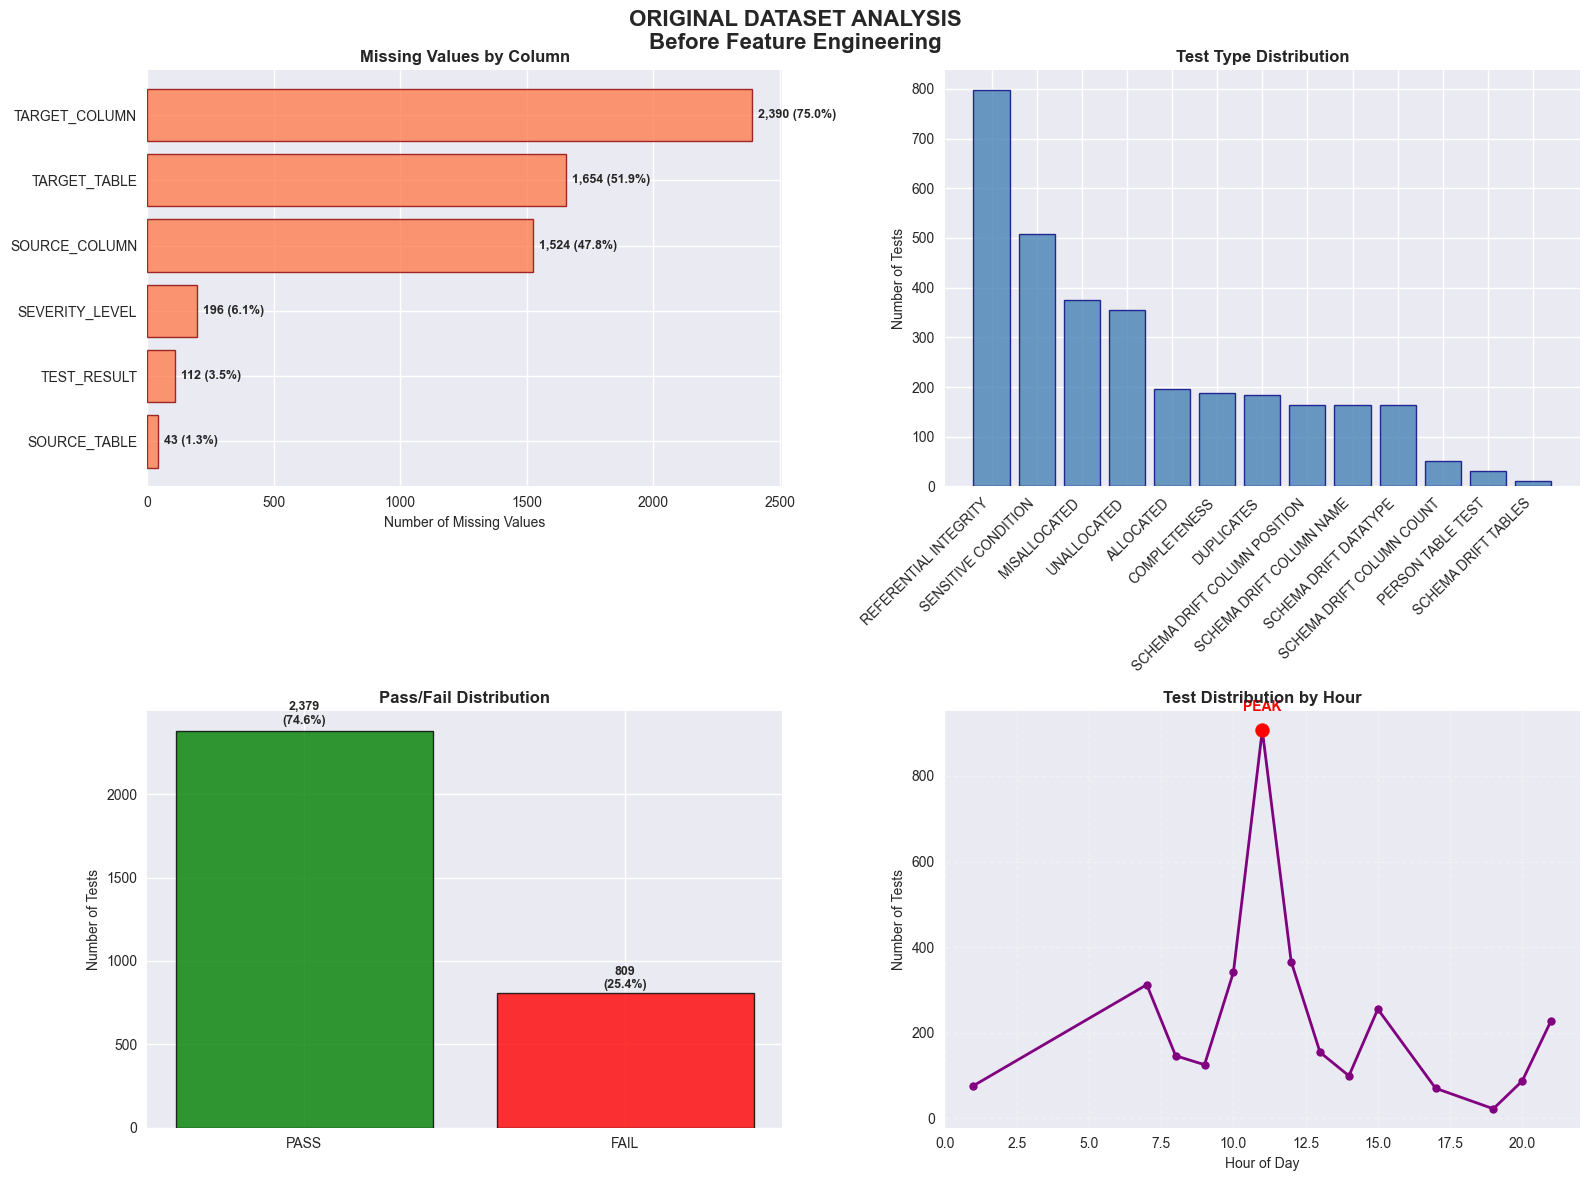


ORIGINAL DATASET SUMMARY:
----------------------------------------
   • Total records: 3,188
   • Original features: 18
   • Data completeness: 89.7%
   • Overall pass rate: 74.6%
   • Unique test types: 13
   • Time span: 79 days

KEY OBSERVATIONS:
----------------------------------------
   • Missing values detected in 6 columns
   • Most affected: SOURCE_TABLE (1.3% missing)
   • Low pass rate (74.6%) - requires attention

READY FOR FEATURE ENGINEERING:
   Dataset structure validated and ready for TEST_CATEGORY and TEST_FAMILY derivation


In [26]:
# ===============================================
# INITIAL DATASET MISSINGNESS AND EDA ANALYSIS
# ===============================================
# This analysis examines the dataset BEFORE adding TEST_CATEGORY and TEST_FAMILY columns
# to understand the original data structure and quality

print("=" * 70)
print("INITIAL DATASET ANALYSIS - BEFORE FEATURE ENGINEERING")
print("=" * 70)

# Load fresh dataset to analyze original structure
df_initial = pd.read_csv('../data/pseudo_deident.csv')

print(f"\nORIGINAL DATASET STRUCTURE:")
print("-" * 40)
print(f"   • Dataset Shape: {df_initial.shape}")
print(f"   • Original Columns: {list(df_initial.columns)}")
print(f"   • Data Types:")
for col, dtype in df_initial.dtypes.items():
    print(f"     - {col:20}: {dtype}")

# ===============================================
# MISSING VALUES ANALYSIS ON ORIGINAL DATASET
# ===============================================

print(f"\nMISSING VALUES ANALYSIS - ORIGINAL DATASET:")
print("-" * 40)

# Calculate missing values for original dataset
missing_values_initial = df_initial.isnull().sum()
missing_percentage_initial = (missing_values_initial / len(df_initial)) * 100

# Create missing values dataframe
missing_df_initial = pd.DataFrame({
    'Missing Count': missing_values_initial,
    'Missing Percentage': missing_percentage_initial
})

# Filter to show only columns with missing values
columns_with_missing_initial = missing_df_initial[missing_df_initial['Missing Count'] > 0]

print(f"MISSING VALUES SUMMARY:")
if len(columns_with_missing_initial) == 0:
    print("   EXCELLENT: No missing values found in the original dataset!")
else:
    print(f"   ATTENTION: {len(columns_with_missing_initial)} columns have missing values")
    print("   Details:")
    print(columns_with_missing_initial.round(2))
    
    # Data quality assessment
    max_missing_pct_initial = missing_percentage_initial.max()
    if max_missing_pct_initial > 20:
        print(f"   HIGH IMPACT: {max_missing_pct_initial:.1f}% missing in worst column")
    elif max_missing_pct_initial > 5:
        print(f"   MODERATE IMPACT: {max_missing_pct_initial:.1f}% missing in worst column")
    else:
        print(f"   LOW IMPACT: {max_missing_pct_initial:.1f}% missing in worst column")

# ===============================================
# ORIGINAL DATASET EDA - DISTRIBUTIONS
# ===============================================

print(f"\nORIGINAL DATASET EXPLORATORY ANALYSIS:")
print("-" * 40)

# Analyze categorical variables in original dataset
original_categorical = ['NAME_OF_TEST', 'STATUS', 'SEVERITY_LEVEL', 'SOURCE_DATABASE', 'SOURCE_SCHEMA']

print("CATEGORICAL VARIABLE DISTRIBUTIONS:")
for col in original_categorical:
    if col in df_initial.columns:
        unique_count = df_initial[col].nunique()
        value_counts = df_initial[col].value_counts()
        print(f"\n{col}:")
        print(f"   • Unique values: {unique_count}")
        print(f"   • Top 3 values:")
        for i, (value, count) in enumerate(value_counts.head(3).items()):
            percentage = (count / len(df_initial)) * 100
            print(f"     {i+1}. {value}: {count:,} ({percentage:.1f}%)")

# ===============================================
# ORIGINAL DATASET TEMPORAL ANALYSIS
# ===============================================

print(f"\nTEMPORAL ANALYSIS - ORIGINAL DATASET:")
print("-" * 40)

# Convert timestamp and extract temporal features
df_initial['RUN_TIMESTAMP'] = pd.to_datetime(df_initial['RUN_TIMESTAMP'])
df_initial['RUN_HOUR'] = df_initial['RUN_TIMESTAMP'].dt.hour

print("TEMPORAL PATTERNS:")
hourly_dist = df_initial['RUN_HOUR'].value_counts().sort_index()
peak_hour = hourly_dist.idxmax()
peak_count = hourly_dist.max()
print(f"   • Peak testing hour: {peak_hour}:00 ({peak_count:,} tests)")
print(f"   • Time range: {df_initial['RUN_TIMESTAMP'].min()} to {df_initial['RUN_TIMESTAMP'].max()}")

# ===============================================
# ORIGINAL DATASET TEST RESULTS ANALYSIS
# ===============================================

print(f"\nTEST RESULTS ANALYSIS - ORIGINAL DATASET:")
print("-" * 40)

# Convert TEST_RESULT to numeric
df_initial['TEST_RESULT_NUMERIC'] = pd.to_numeric(df_initial['TEST_RESULT'], errors='coerce')

print("TEST RESULT STATISTICS:")
test_results_clean = df_initial['TEST_RESULT_NUMERIC'].dropna()
if len(test_results_clean) > 0:
    print(f"   • Mean issues per test: {test_results_clean.mean():.2f}")
    print(f"   • Median issues per test: {test_results_clean.median():.2f}")
    print(f"   • Max issues found: {test_results_clean.max():,.0f}")
    print(f"   • Zero results (perfect tests): {(test_results_clean == 0).sum():,}")

# Pass/Fail analysis
pass_count = (df_initial['STATUS'] == 'PASS').sum()
fail_count = (df_initial['STATUS'] == 'FAIL').sum()
pass_rate = (pass_count / len(df_initial)) * 100
print(f"\nPASS/FAIL ANALYSIS:")
print(f"   • Pass rate: {pass_rate:.1f}% ({pass_count:,} tests)")
print(f"   • Fail rate: {100-pass_rate:.1f}% ({fail_count:,} tests)")

# ===============================================
# VISUALIZATION: ORIGINAL DATASET OVERVIEW
# ===============================================

print(f"\nCREATING ORIGINAL DATASET VISUALIZATIONS:")
print("-" * 40)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('ORIGINAL DATASET ANALYSIS\nBefore Feature Engineering', fontsize=16, fontweight='bold')

# Plot 1: Missing values bar chart
if len(columns_with_missing_initial) > 0:
    chart_data = columns_with_missing_initial.sort_values('Missing Count', ascending=True)
    bars = axes[0,0].barh(chart_data.index, chart_data['Missing Count'], 
                         color='coral', alpha=0.8, edgecolor='darkred', linewidth=1)
    axes[0,0].set_title('Missing Values by Column', fontsize=12, fontweight='bold')
    axes[0,0].set_xlabel('Number of Missing Values', fontsize=10)
    
    # Add annotations
    for i, (bar, count, pct) in enumerate(zip(bars, chart_data['Missing Count'], 
                                              chart_data['Missing Percentage'])):
        axes[0,0].text(bar.get_width() + max(chart_data['Missing Count']) * 0.01, 
                      bar.get_y() + bar.get_height()/2, 
                      f'{int(count):,} ({pct:.1f}%)', 
                      va='center', ha='left', fontweight='bold', fontsize=9)
else:
    axes[0,0].text(0.5, 0.5, 'NO MISSING VALUES\nData Quality: EXCELLENT', 
                  horizontalalignment='center', verticalalignment='center',
                  fontsize=14, fontweight='bold', color='green',
                  bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
    axes[0,0].set_title('Missing Values Analysis', fontsize=12, fontweight='bold')
    axes[0,0].axis('off')

# Plot 2: Test type distribution
test_counts = df_initial['NAME_OF_TEST'].value_counts()
bars = axes[0,1].bar(range(len(test_counts)), test_counts.values, 
                    color='steelblue', alpha=0.8, edgecolor='navy', linewidth=1)
axes[0,1].set_title('Test Type Distribution', fontsize=12, fontweight='bold')
axes[0,1].set_ylabel('Number of Tests', fontsize=10)
axes[0,1].set_xticks(range(len(test_counts)))
axes[0,1].set_xticklabels(test_counts.index, rotation=45, ha='right')

# Plot 3: Pass/Fail rates
status_counts = df_initial['STATUS'].value_counts()
colors = ['green' if status == 'PASS' else 'red' for status in status_counts.index]
bars = axes[1,0].bar(status_counts.index, status_counts.values, 
                    color=colors, alpha=0.8, edgecolor='black', linewidth=1)
axes[1,0].set_title('Pass/Fail Distribution', fontsize=12, fontweight='bold')
axes[1,0].set_ylabel('Number of Tests', fontsize=10)

# Add percentage labels
for i, (bar, count) in enumerate(zip(bars, status_counts.values)):
    percentage = (count / len(df_initial)) * 100
    axes[1,0].text(bar.get_x() + bar.get_width()/2., bar.get_height() + count*0.01,
                  f'{count:,}\n({percentage:.1f}%)', 
                  ha='center', va='bottom', fontweight='bold', fontsize=9)

# Plot 4: Hourly distribution
hourly_counts = df_initial['RUN_HOUR'].value_counts().sort_index()
axes[1,1].plot(hourly_counts.index, hourly_counts.values, 
               marker='o', linewidth=2, markersize=6, color='purple')
axes[1,1].set_title('Test Distribution by Hour', fontsize=12, fontweight='bold')
axes[1,1].set_xlabel('Hour of Day', fontsize=10)
axes[1,1].set_ylabel('Number of Tests', fontsize=10)
axes[1,1].grid(True, alpha=0.3, linestyle='--')

# Highlight peak hour
axes[1,1].scatter([peak_hour], [peak_count], color='red', s=100, zorder=5)
axes[1,1].text(peak_hour, peak_count + peak_count*0.05, 'PEAK', 
               ha='center', fontweight='bold', color='red')

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

# ===============================================
# SUMMARY AND INSIGHTS
# ===============================================

print(f"\nORIGINAL DATASET SUMMARY:")
print("-" * 40)
print(f"   • Total records: {len(df_initial):,}")
print(f"   • Original features: {df_initial.shape[1]}")
print(f"   • Data completeness: {(1 - missing_values_initial.sum() / (len(df_initial) * df_initial.shape[1])) * 100:.1f}%")
print(f"   • Overall pass rate: {pass_rate:.1f}%")
print(f"   • Unique test types: {df_initial['NAME_OF_TEST'].nunique()}")
print(f"   • Time span: {(df_initial['RUN_TIMESTAMP'].max() - df_initial['RUN_TIMESTAMP'].min()).days} days")

print(f"\nKEY OBSERVATIONS:")
print("-" * 40)
if len(columns_with_missing_initial) > 0:
    print(f"   • Missing values detected in {len(columns_with_missing_initial)} columns")
    print(f"   • Most affected: {columns_with_missing_initial.index[0]} ({columns_with_missing_initial['Missing Percentage'].iloc[0]:.1f}% missing)")
else:
    print("   • No missing values - excellent data quality")

if pass_rate > 90:
    print(f"   • High pass rate ({pass_rate:.1f}%) indicates good overall data quality")
elif pass_rate > 80:
    print(f"   • Moderate pass rate ({pass_rate:.1f}%) - room for improvement")
else:
    print(f"   • Low pass rate ({pass_rate:.1f}%) - requires attention")

print(f"\nREADY FOR FEATURE ENGINEERING:")
print("   Dataset structure validated and ready for TEST_CATEGORY and TEST_FAMILY derivation")
print("=" * 70)

In [33]:
df = df_initial
df["DQ_EVENT"] = df.apply(utils.parse_test_event, axis=1)
df["TEST_CATEGORY"] = df["NAME_OF_TEST"].apply(lambda x: derive_category(x))
df["TEST_FAMILY"] = df["NAME_OF_TEST"].apply(lambda x: derive_test_family(x))

#ML-ready features
df["STATUS"] = df["DQ_EVENT"].apply(lambda x: x["status"])
df["ADDED_COLUMNS"] = df["DQ_EVENT"].apply(lambda x: len(x["metrics"].get("added_columns", [])))
df["REMOVED_COLUMNS"] = df["DQ_EVENT"].apply(lambda x: len(x["metrics"].get("removed_columns", [])))
df["COLUMN_POSITION_CHANGES"] = df["DQ_EVENT"].apply(lambda x: len(x["metrics"].get("changed_positions", {})))
df["CASE_MISMATCHES"] = df["DQ_EVENT"].apply(lambda x: len(x["metrics"].get("case_mismatches", {})))

In [32]:
df.head()

,TEST_RUN_ID,NAME_OF_TEST,SOURCE_DATABASE,SOURCE_SCHEMA,SOURCE_TABLE,SOURCE_COLUMN,TARGET_DATABASE,TARGET_SCHEMA,TARGET_TABLE,TARGET_COLUMN,TEST_RESULT,STATUS,DETAILS,SEVERITY_LEVEL,RUN_TIMESTAMP,IS_LATEST,RUN_HOUR,TEST_RESULT_NUMERIC,TEST_CATEGORY,TEST_FAMILY,DQ_EVENT
0,RUN_421,DUPLICATES,SOURCE_DATABASE_443,SOURCE_SCHEMA_941,ORGANISATION,LDS_ID,TARGET_DATABASE_777,TARGET_SCHEMA_777,NaN,NaN,0,PASS,Duplicates do not exist in LDS_ID column,MEDIUM SEVERITY,2025-12-22 13:51:13,0,13,0.00,UNIQUENESS,UNIQUENESS,"{'test_family': 'UNIQUENESS', 'test_category':..."
1,RUN_421,DUPLICATES,SOURCE_DATABASE_443,SOURCE_SCHEMA_941,LOCATION_CONTACT,LDS_ID,TARGET_DATABASE_777,TARGET_SCHEMA_777,NaN,NaN,0,PASS,Duplicates do not exist in LDS_ID column,MEDIUM SEVERITY,2025-12-22 13:51:13,0,13,0.00,UNIQUENESS,UNIQUENESS,"{'test_family': 'UNIQUENESS', 'test_category':..."
2,RUN_421,DUPLICATES,SOURCE_DATABASE_443,SOURCE_SCHEMA_941,PROCEDURE_REQUEST,LDS_ID,TARGET_DATABASE_777,TARGET_SCHEMA_777,NaN,NaN,0,PASS,Duplicates do not exist in LDS_ID column,MEDIUM SEVERITY,2025-12-22 13:51:13,0,13,0.00,UNIQUENESS,UNIQUENESS,"{'test_family': 'UNIQUENESS', 'test_category':..."
3,RUN_421,DUPLICATES,SOURCE_DATABASE_443,SOURCE_SCHEMA_941,SCHEDULE_PRACTITIONER,LDS_ID,TARGET_DATABASE_777,TARGET_SCHEMA_777,NaN,NaN,0,PASS,Duplicates do not exist in LDS_ID column,MEDIUM SEVERITY,2025-12-22 13:51:13,0,13,0.00,UNIQUENESS,UNIQUENESS,"{'test_family': 'UNIQUENESS', 'test_category':..."
4,RUN_421,DUPLICATES,SOURCE_DATABASE_443,SOURCE_SCHEMA_941,MEDICATION_ORDER,LDS_ID,TARGET_DATABASE_777,TARGET_SCHEMA_777,NaN,NaN,0,PASS,Duplicates do not exist in LDS_ID column,MEDIUM SEVERITY,2025-12-22 13:51:13,0,13,0.00,UNIQUENESS,UNIQUENESS,"{'test_family': 'UNIQUENESS', 'test_category':..."


In [ ]:

#save csv with DQ_Events 
df.to_csv('../data/events.csv', index=False)

## Generate engineered datasets (standard + irregular)

This writes:
- `data/feature_engineered_events.csv` (standard temporal periods)
- `data/feature_engineered_events_irregular.csv` (irregular temporal periods/ AI-agent-ready)


In [34]:
import importlib
import enhanced_preprocessing_pipeline
import irregular_time_series_processor

importlib.reload(irregular_time_series_processor)
importlib.reload(enhanced_preprocessing_pipeline)

from enhanced_preprocessing_pipeline import run_enhanced_preprocessing_pipeline

standard_df, irregular_df = run_enhanced_preprocessing_pipeline(
    data_dir=DATA_DIR,
    output_dir=DATA_DIR,
    input_filename='events.csv',
    output_filename='feature_engineered_events.csv',
    generate_irregular=True,
)

print('Standard engineered shape:', None if standard_df is None else standard_df.shape)
print('Irregular engineered shape:', None if irregular_df is None else irregular_df.shape)
print('Irregular dataset saved to:', DATA_DIR / 'feature_engineered_events_irregular.csv')


INFO:enhanced_preprocessing_pipeline:================================================================================
INFO:enhanced_preprocessing_pipeline:STARTING ENHANCED HEALTHCARE DQ FEATURE ENGINEERING PIPELINE
INFO:enhanced_preprocessing_pipeline:================================================================================
INFO:enhanced_preprocessing_pipeline:Step 1: Running standard feature engineering...
INFO:preprocessing_utils:============================================================
INFO:preprocessing_utils:STARTING HEALTHCARE DQ FEATURE ENGINEERING PIPELINE
INFO:preprocessing_utils:============================================================
INFO:preprocessing_utils:Step 1: Loading raw data...
INFO:preprocessing_utils:Loading data from C:\Users\Angela.Ebirim\CascadeProjects\Capstone_Project_ML_DQ_SCORE\data\events.csv
INFO:preprocessing_utils:Using RUN_TIMESTAMP as datetime index with temporal features extracted
INFO:preprocessing_utils:Converted 3188 valid timestamps

=== IRREGULAR TIME SERIES ANALYSIS ===
Data shape: (19, 286)
Date range: 2025-10-03 00:00:00 to 2025-12-22 00:00:00
Total days in range: 81
Actual data points: 19
Data sparsity: 23.5%

=== TEMPORAL GAP ANALYSIS ===
Average gap between measurements: 4.4 days
Median gap: 3.0 days
Maximum gap: 17.0 days
Minimum gap: 1.0 days

Gap distribution (top 10):
  1 days gap: 5 occurrences
  2 days gap: 3 occurrences
  3 days gap: 2 occurrences
  4 days gap: 2 occurrences
  5 days gap: 2 occurrences
  7 days gap: 1 occurrences
  8 days gap: 1 occurrences
  13 days gap: 1 occurrences
  17 days gap: 1 occurrences

=== CREATING IRREGULAR TIME SERIES FEATURES ===
Removed 48 temporal features that assume regular intervals
Found 0 features with infinite values
Renamed 8 pct_change features to reflect lag-by-observation semantics
Creating gap-aware trend features...
Creating frequency-based features...

Final processed dataset shape: (19, 250)
Features created for irregular time series: 250

=== PREPARING

## Forecast next measurement DQ_SCORE (production-style auto-selection)

This runs walk-forward evaluation to rank models by RMSE (including a naive baseline), then produces a next-measurement forecast from the latest available row.


In [39]:
from IPython.display import display
from auto_forecast import train_and_forecast_next

result = train_and_forecast_next(
    data_path=DATA_DIR / 'feature_engineered_events_irregular.csv',
    output_models_dir=PROJECT_ROOT / 'models',
    #mode='post_run',  # use 'pre_run' if forecasting BEFORE a run completes
    mode='post_run',
    save_artifact=True,
    include_comparison_table=False,
)

print('Latest measurement date:', result.latest_date)
print('Selected model:', result.selected_model)
print('Forecasted next DQ_SCORE:', result.predicted_next_dq_score)
print('Naive next DQ_SCORE:', result.naive_predicted_next_dq_score)
print('Saved model artifact:', result.artifact_path)

print('\nModel ranking (lower RMSE is better):')
display(result.metrics_summary)


Latest measurement date: 2025-12-22 00:00:00
Selected model: ElasticNet
Forecasted next DQ_SCORE: 0.770244472921507
Naive next DQ_SCORE: 0.7126436781609196
Saved model artifact: C:\Users\Angela.Ebirim\CascadeProjects\Capstone_Project_ML_DQ_SCORE\models\dq_score_next_forecaster_20260112_204906.pkl

Model ranking (lower RMSE is better):


,model,RMSE
0,ElasticNet,0.29
1,DecisionTree(depth=2),0.29
2,Naive(last_value),0.40
3,Ridge,25.00
4,BayesianRidge,28.47


## (Optional) Visualize the Decision Tree (if selected)

This is helpful for interpretability. It trains a shallow tree on `DQ_SCORE_next` and plots splits/leaves.


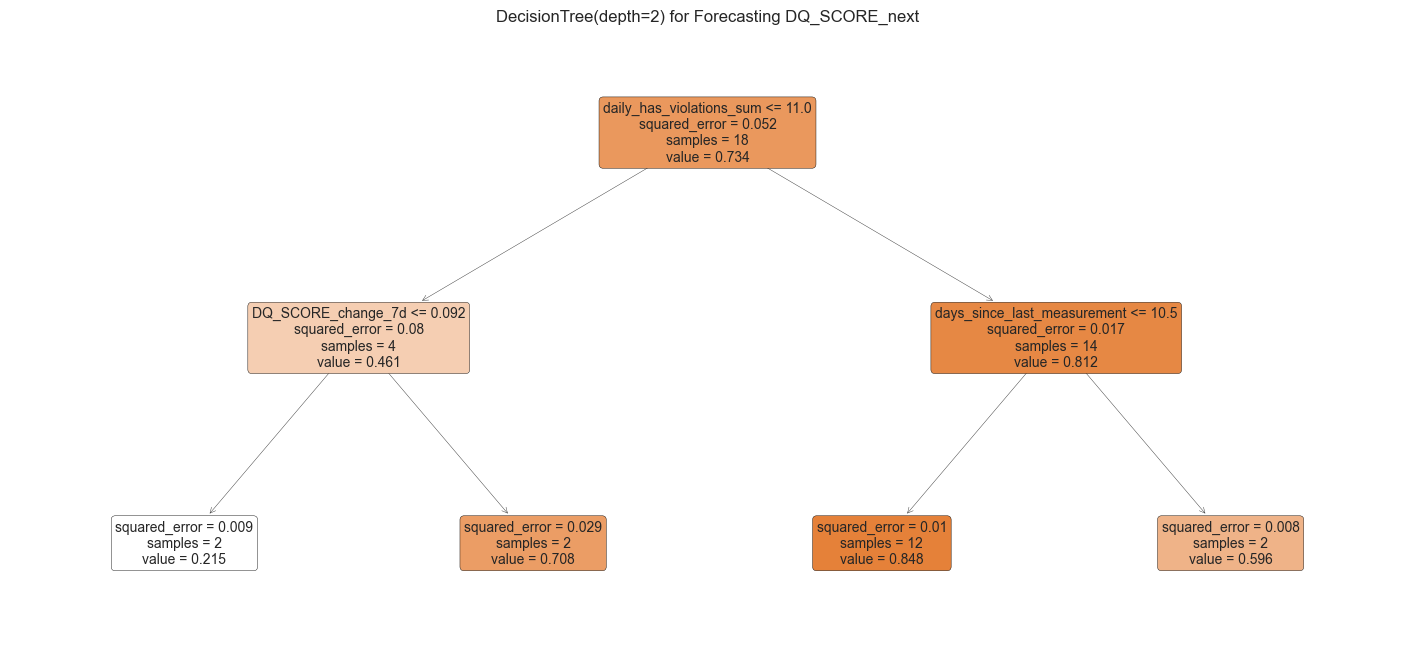

Saved tree visualization to: C:\Users\Angela.Ebirim\CascadeProjects\Capstone_Project_ML_DQ_SCORE\data\decision_tree_forecast.png


In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, plot_tree

df_irregular = pd.read_csv(
    DATA_DIR / 'feature_engineered_events_irregular.csv',
    index_col='calendar_date',
    parse_dates=True,
).sort_index()

df_irregular['DQ_SCORE_next'] = df_irregular['DQ_SCORE'].shift(-1)
df_model = df_irregular.dropna(subset=['DQ_SCORE_next']).copy()

future_cols = [c for c in df_model.columns if 'to_next' in c or c == 'days_to_next_measurement']
if future_cols:
    df_model = df_model.drop(columns=future_cols)

for col in ['DQ_SCORE_CATEGORY', 'TRUST_SCORE_CATEGORY']:
    if col in df_model.columns:
        df_model = df_model.drop(columns=[col])

X = df_model.drop(columns=['DQ_SCORE_next'], errors='ignore').select_dtypes(include=[np.number])
y = df_model['DQ_SCORE_next'].copy()

tree = DecisionTreeRegressor(max_depth=2, min_samples_leaf=2, random_state=42)
tree.fit(X, y)

plt.figure(figsize=(18, 8))
plot_tree(
    tree,
    feature_names=list(X.columns),
    filled=True,
    rounded=True,
    precision=3,
    fontsize=10,
)
plt.title('DecisionTree(depth=2) for Forecasting DQ_SCORE_next')

out_path = DATA_DIR / 'decision_tree_forecast.png'
plt.savefig(out_path, dpi=200, bbox_inches='tight')
plt.show()

print('Saved tree visualization to:', out_path)
